In [11]:
!pip install -U kaleido

In [12]:
# This Code places the Vacancies (VAC)s into given W-V (Tungsten-Vanadium) supercell 
# by minimizing the average distance between VAC atoms and maximizing the average distance between V and VAC atoms 
# considering periodic boundary conditions. 

import numpy as np
from itertools import combinations
from tqdm import tqdm
import math
import datetime
from itertools import combinations
import plotly.graph_objs as go
import random
import kaleido
from IPython.display import Image, display

# Read coordinates from the input file of 3V case
coordinates_3v = []
with open("/kaggle/input/coordinates-3v/coordinates_3Vatoms.txt", "r") as file:
    for line in file:
        coords = list(map(float, line.split()))
        coordinates_3v.append(coords)
    print("Coordinates are obtained total atoms:",len(coordinates_3v))

vanadium_atoms = [125, 126, 127] #predifined from input file
num_atoms = len(coordinates_3v)
cell_lengths=[1,1,1]
coordinates_3v = np.array(coordinates_3v)

# Precompute distances between all atoms
all_distances_3v = np.zeros((num_atoms, num_atoms))
for i in range(num_atoms):
    for j in range(i + 1, num_atoms):
        diff = coordinates_3v[i] - coordinates_3v[j]
        if cell_lengths is not None:
            diff -= np.round(diff / cell_lengths) * cell_lengths
        dist = np.linalg.norm(diff)
        all_distances_3v[i, j] = dist
        all_distances_3v[j, i] = dist

Coordinates are obtained total atoms: 128


In [13]:
def decorate_atoms(coordinates_3v, num_selected, excluded_atoms=None):
    """
    Generate all possible selections of num_selected different atoms from given coordinates.

    Args:
    - coordinates (list): List of coordinate tuples, where each tuple represents the coordinates of an atom.
    - num_selected (int): Number of atoms to select in each pair.

    Returns:
    - pairs (generator): A generator yielding pairs of atom indices.
    """

    # Use itertools.combinations as a generator
    if excluded_atoms is not None:
      for atoms in combinations([idx for idx in range(len(coordinates_3v)) if idx not in excluded_atoms], num_selected):
          yield atoms
    else:
      for atoms in combinations(range(len(coordinates_3v)), num_selected):
          yield atoms

def calculate_avg_dist(atom_ids, verbose=0,all_distances=all_distances_3v):
    """
    Calculate all distances between given atom IDs, considering periodic boundary conditions.

    Args:
    - atom_ids (list): List of atom IDs for which distances are to be calculated.
    - verbose (int, optional): If larger than 0, print all calculated coordinates and distances
    Returns:
    - average_distance (float): Average of all distances between the given atom IDs.
    """
    distances = []
    # Calculate distances between given atom IDs using precomputed distances
    for i in range(len(atom_ids)):
        for j in range(i + 1, len(atom_ids)):
            dist = all_distances[atom_ids[i], atom_ids[j]]
            distances.append(dist)

            if verbose > 1:
                print(f"Distance between atoms {atom_ids[i]} and {atom_ids[j]}: {dist:.4f}")

    # Calculate average distance
    if distances:
        average_distance = sum(distances) / len(distances)
    else:
        average_distance = 0.0

    return average_distance

In [14]:
# Plot supercell with V atoms and Vacancies 
def plot_atoms(vanadium=None,coordinates=coordinates_3v,vacancy=None):
    # Generate two random indices
    # idx1, idx2 = random.sample(range(len(coordinates)), 2)
 
    # Extracting x, y, z coordinates
    x_coords, y_coords, z_coords = zip(*coordinates)
 
    # Create list of colors for all markers
    colors = ['gray'] * len(coordinates)
    # colors[idx1] = 'blue'
    # colors[idx2] = 'green'
 
    if vanadium is not None:
      for atom_id in vanadium:
          colors[atom_id] = 'red'
 
    if vacancy is not None:
      for atom_id in vacancy:
          colors[atom_id] = 'white'
 
    # Create trace
    trace = go.Scatter3d(
        x=x_coords,
        y=y_coords,
        z=z_coords,
        mode='markers',
        marker=dict(
            size=8,
            color=colors,
            symbol='circle',  # Marker symbol
            line=dict(color='rgb(0,0,0)', width=1)
        )
    )
 
    # Create layout
    layout = go.Layout(
        scene=dict(
            xaxis=dict(title='X'),
            yaxis=dict(title='Y'),
            zaxis=dict(title='Z')
        ),
        title='3D Visualization of Atoms with Randomly Colored Atoms'
    )
 
    # Create figure
    fig = go.Figure(data=[trace], layout=layout)
    # Save figure
    fig.write_image("atoms_plot_3v_max.png")
    # Show plot
    fig.show()

In [15]:
# Define number of Vacancies atom to be placed
num_selected = 3
decorator = decorate_atoms(coordinates_3v, num_selected, vanadium_atoms)

min_dist=99999999
selected_atoms=[]
max_search= 317_750 # 317_750 possible cases for 3 VACs
max_tot_dist_van=0


for i, pair in tqdm(enumerate(decorator), total=max_search ,mininterval=60):
    if i < max_search:
        atom_ids = list(pair)
        average_distance = round(calculate_avg_dist( atom_ids, verbose=0, all_distances=all_distances_3v), 7)

        if average_distance < min_dist:
            min_dist = average_distance
            max_tot_dist_van = 0.0 

            for atom in [125, 126, 127]:
                max_tot_dist_van += np.square(round(calculate_avg_dist( atom_ids+[atom], verbose=0, all_distances=all_distances_3v), 7))
                
            max_tot_dist_van = round(max_tot_dist_van, 7)
            selected_atoms = atom_ids
            print(i,":",atom_ids)
            print("Average distance between the given VAC IDs:", min_dist)
            print("Average distance between the given VAC+VAN IDs:", max_tot_dist_van)
        elif average_distance == min_dist:
            tot_dist_van = 0.0
            for atom in [125, 126, 127]:
                tot_dist_van += np.square(round(calculate_avg_dist( atom_ids+[atom], verbose=0, all_distances=all_distances_3v), 7))
            tot_dist_van = round(tot_dist_van, 7)
    
            if tot_dist_van > max_tot_dist_van:
                max_tot_dist_van = tot_dist_van
                selected_atoms = atom_ids
                print(i,":",atom_ids)
                print("Average distance between the given VAC IDs:", min_dist)
                print("Average distance between the given VAC+VAN IDs:", max_tot_dist_van)
                
            # plot_atoms(pair,coordinates)
    else:
        break

  0%|          | 0/317750 [00:00<?, ?it/s]

0 : [0, 1, 2]
Average distance between the given VAC IDs: 0.3333333
Average distance between the given VAC+VAN IDs: 0.4918945
2 : [0, 1, 4]
Average distance between the given VAC IDs: 0.2845178
Average distance between the given VAC+VAN IDs: 0.4261367
3 : [0, 1, 5]
Average distance between the given VAC IDs: 0.2845178
Average distance between the given VAC+VAN IDs: 0.4295046
60 : [0, 1, 62]
Average distance between the given VAC IDs: 0.2276709
Average distance between the given VAC+VAN IDs: 0.3532085
5621 : [0, 61, 73]
Average distance between the given VAC IDs: 0.2276709
Average distance between the given VAC+VAN IDs: 0.3538939
22566 : [3, 4, 61]
Average distance between the given VAC IDs: 0.2276709
Average distance between the given VAC+VAN IDs: 0.3763921
22570 : [3, 4, 65]
Average distance between the given VAC IDs: 0.2276709
Average distance between the given VAC+VAN IDs: 0.3943652
22924 : [3, 7, 65]
Average distance between the given VAC IDs: 0.2276709
Average distance between the

100%|██████████| 317750/317750 [00:02<00:00, 113105.07it/s]


In [16]:
plot_atoms(vanadium=vanadium_atoms,coordinates=coordinates_3v,vacancy=selected_atoms)

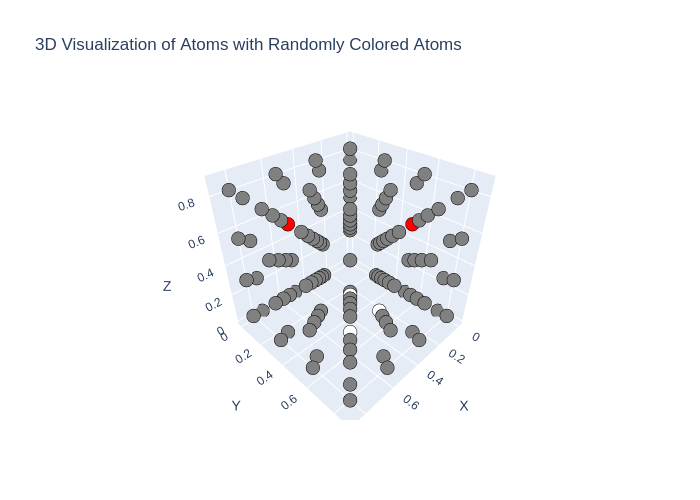

In [17]:
display(Image(filename='atoms_plot_3v_max.png'))